# Importing libraries and initialising data


In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 


In [2]:
print(tf.__version__)

2.10.0


## Getting train and testing data

In [3]:
(x_train, y_train), (x_rem, y_rem) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
from sklearn.model_selection import train_test_split

x_valid, x_test, y_valid, y_test = train_test_split(x_rem,y_rem, test_size=0.5)
print(x_train.shape), print(y_train.shape)
print(x_valid.shape), print(y_valid.shape)
print(x_test.shape), print(y_test.shape)

(60000, 28, 28)
(60000,)
(5000, 28, 28)
(5000,)
(5000, 28, 28)
(5000,)


(None, None)

# Problem Statement

## Implement an image classifier using a deep learning network. 

### X_train and x_test are 28x28 images of fashion items. The y_train and y_test are the labels for the images. 
The labels are integers from 0 to 9. The labels are as follows:
List of labels
| Label       | Description |
| ----------- | ----------- |
| 0           | T-shirt/Top |
| 1           | Trouser     |
| 2           | Pullover    |
| 3           | Dress       |
| 4           | Coat        |
| 5           | Sandal      |
| 6           | Shirt       |
| 7           | Sneaker     |
| 8           | Bag         |
| 9           | Ankle Boot  |


Image dimmensions are 28x28.

The train set and test set are given in two separate datasets.

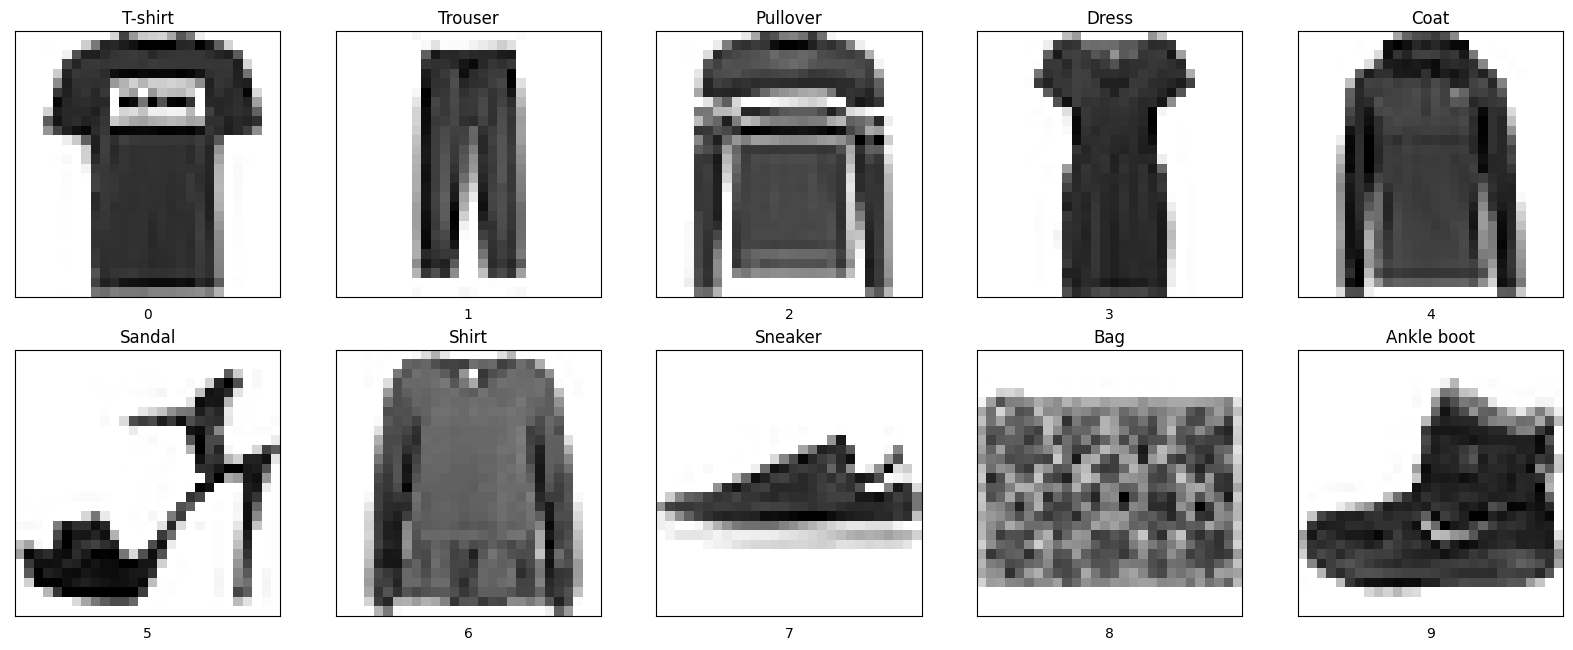

In [5]:
array_of_each_class_position = [1,21,5,20,24,9,18,6,23,0]
# plot all images in array_of_each_class_position
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(20,20))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(class_names[i])
    plt.imshow(tf.keras.datasets.fashion_mnist.load_data()[0][0][array_of_each_class_position[i]], cmap=plt.cm.binary)
    plt.xlabel(tf.keras.datasets.fashion_mnist.load_data()[0][1][array_of_each_class_position[i]])
plt.show()

# EDA

## Distribution of Data

In [6]:
# Create a dictionary for each type of label 
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

def get_classes_distribution(data):
    # Get the count for each label
    label_counts = data["label"].value_counts()

    # Get total number of samples
    total_samples = len(data)


    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))

get_classes_distribution(pd.DataFrame(y_train, columns=["label"]))

Ankle Boot          :   6000 or 10.0%
T-shirt/top         :   6000 or 10.0%
Dress               :   6000 or 10.0%
Pullover            :   6000 or 10.0%
Sneaker             :   6000 or 10.0%
Sandal              :   6000 or 10.0%
Trouser             :   6000 or 10.0%
Shirt               :   6000 or 10.0%
Coat                :   6000 or 10.0%
Bag                 :   6000 or 10.0%


## Normalizing the data

In [7]:
x_train = x_train.reshape(60000,28,28,1)/255
x_test= x_test.reshape(5000,28,28,1)/255
x_valid = x_valid.reshape(5000,28,28,1)/255

# Info for building models

The Sequential model is a linear stack of layers. It can be first initialized and then we add layers using add method or we can add all layers at init stage. The layers added are as follows:

Conv2D is a 2D Convolutional layer (i.e. spatial convolution over images). The parameters used are:

filters - the number of filters (Kernels) used with this layer; here filters = 32;
kernel_size - the dimmension of the Kernel: (3 x 3);
activation - is the activation function used, in this case relu;
kernel_initializer - the function used for initializing the kernel;
input_shape - is the shape of the image presented to the CNN: in our case is 28 x 28 The input and output of the Conv2D is a 4D tensor.
MaxPooling2D is a Max pooling operation for spatial data. Parameters used here are:

pool_size, in this case (2,2), representing the factors by which to downscale in both directions;

Conv2D with the following parameters:

filters: 64;
kernel_size : (3 x 3);
activation : relu;
MaxPooling2D with parameter:

pool_size : (2,2);
Conv2D with the following parameters:

filters: 128;
kernel_size : (3 x 3);
activation : relu;
Flatten. This layer Flattens the input. Does not affect the batch size. It is used without parameters;

Dense. This layer is a regular fully-connected NN layer. It is used without parameters;

units - this is a positive integer, with the meaning: dimensionality of the output space; in this case is: 128;
activation - activation function : relu;
Dense. This is the final layer (fully connected). It is used with the parameters:

units: the number of classes (in our case 10);
activation : softmax; for this final layer it is used softmax activation (standard for multiclass classification)
Then we compile the model, specifying as well the following parameters:

In [8]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten, Dropout , BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Model 1 - Basic CNN (Stupid baseline)

In [9]:
# reshape dataset to have a single channel
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10)
])


In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
model.fit(x_train,y_train , epochs=10)

model.summary()

Epoch 1/10
1875/1875 [==============================] - 15s 5ms/step - loss: 0.4992 - accuracy: 0.8247
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.3771 - accuracy: 0.8639
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.3404 - accuracy: 0.8761
Epoch 4/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.3140 - accuracy: 0.8853
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2967 - accuracy: 0.8904
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2814 - accuracy: 0.8955
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2706 - accuracy: 0.8996
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2609 - accuracy: 0.9030
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2496 - accuracy: 0.9061
Epoch 10/10
1875/1875 [==============================] - 10s 5ms/step - loss: 

# Model 2 - Adding more layers

## Trying out with batch normalization/dropout

### Definition collection

In [12]:
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from keras.models import load_model
import visualkeras
from PIL import ImageFont
from sklearn.metrics import classification_report

def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace

def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
   
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])

    
    iplot(fig, filename=f'accuracy-loss_{train_model}')
    
def plot_graph(model_name):
    score = model_name.model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    accuracy = model_name.history['accuracy']
    val_accuracy = model_name.history['val_accuracy']
    loss = model_name.history['loss']
    val_loss = model_name.history['val_loss']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
def print_classification(model_hdf5):

    #locate index of '1' in each row
    cnn_best = load_model(model_hdf5)
    #Confirm loss and accuracy on the test data
    cnn_best.evaluate(x_test,y_test)
    #get the predictions for the test data
    preds = cnn_best.predict(x_test)
    preds = np.argmax(np.round(preds),axis=1)
    print(preds)

    #outputing as classifcation matrix to see the accuracy of each class

    labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
            "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
    #get the indices to be plotted
    correct = np.nonzero(preds==y_test)[0]
    incorrect = np.nonzero(preds!=y_test)[0]
    target_names = ["Item {} {}".format(labels[i], i) for i in range(10)]
    print(classification_report(y_test, preds, target_names=target_names))
 
def visualise_keras(model,number):

    visualkeras.layered_view(model).show()
    visualkeras.layered_view(model, to_file=f'output{number}.png')
    font = ImageFont.truetype("arial.ttf", 32)  # using comic sans is strictly prohibited!
    visualkeras.layered_view(model, legend=True, font=font)  # font is optional!

In [13]:
model_2 = Sequential()
model_2.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28,28,1),padding='same'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.2))
model_2.add(Conv2D(32, kernel_size=3, activation='relu',padding='same'))
model_2.add(Dropout(0.2))
model_2.add(Conv2D(24, kernel_size=3, activation='relu',padding='same'))
model_2.add(Dropout(0.4))
model_2.add(Conv2D(64, kernel_size=3, activation='relu',padding='same'))
model_2.add(MaxPooling2D(pool_size=(2,2)))
model_2.add(Dropout(0.3))
model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(10, activation='softmax'))

model_2.compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 28, 28, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 24)        6936      
                                                      

In [14]:
# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint('best_model2_DO_BN.hdf5', save_best_only = True)
# Early stop on validation accuracy
monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 5)

In [15]:
history = model_2.fit(x_train,y_train,
        batch_size=256,
          epochs=50,
          verbose=1,
          callbacks=[checkpoint, monitor_val_acc],
          validation_data = (x_valid, y_valid))

Epoch 1/50
235/235 [==============================] - 21s 47ms/step - loss: 0.8186 - accuracy: 0.7162 - val_loss: 1.5511 - val_accuracy: 0.8414
Epoch 2/50
235/235 [==============================] - 10s 41ms/step - loss: 0.4419 - accuracy: 0.8412 - val_loss: 0.7131 - val_accuracy: 0.8754
Epoch 3/50
235/235 [==============================] - 10s 41ms/step - loss: 0.3886 - accuracy: 0.8593 - val_loss: 0.3330 - val_accuracy: 0.8886
Epoch 4/50
235/235 [==============================] - 8s 33ms/step - loss: 0.3529 - accuracy: 0.8725 - val_loss: 0.2940 - val_accuracy: 0.8944
Epoch 5/50
235/235 [==============================] - 7s 30ms/step - loss: 0.3253 - accuracy: 0.8816 - val_loss: 0.2629 - val_accuracy: 0.9028
Epoch 6/50
235/235 [==============================] - 7s 30ms/step - loss: 0.3066 - accuracy: 0.8881 - val_loss: 0.2622 - val_accuracy: 0.9130
Epoch 7/50
235/235 [==============================] - 8s 32ms/step - loss: 0.2915 - accuracy: 0.8948 - val_loss: 0.2473 - val_accuracy: 0.9

In [16]:
visualise_keras(model_2,1)

### Visualising model performance

In [17]:
plot_accuracy_and_loss(history)

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



Test loss: 0.19295746088027954
Test accuracy: 0.9309999942779541


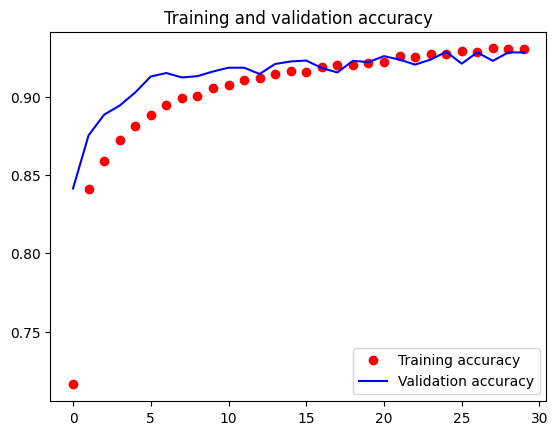

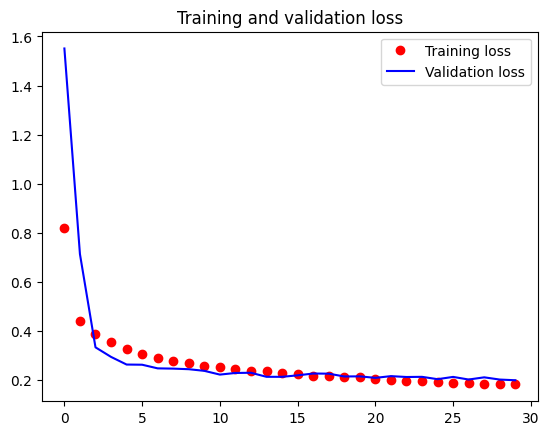

In [25]:
plot_graph(history)

### Model evaluation

In [28]:
print_classification('best_model2_DO_BN.hdf5')

157/157 [==============================] - 1s 5ms/step
[2 3 0 ... 0 6 4]
                    precision    recall  f1-score   support

Item T-shirt/top 0       0.76      0.93      0.84       524
    Item Trouser 1       1.00      0.98      0.99       506
   Item Pullover 2       0.91      0.88      0.89       496
      Item Dress 3       0.95      0.92      0.93       478
       Item Coat 4       0.90      0.87      0.89       488
     Item Sandal 5       0.98      0.99      0.99       525
      Item Shirt 6       0.84      0.75      0.80       486
    Item Sneaker 7       0.96      0.98      0.97       488
        Item Bag 8       0.99      0.99      0.99       516
 Item Ankle Boot 9       0.99      0.95      0.97       493

          accuracy                           0.93      5000
         macro avg       0.93      0.92      0.93      5000
      weighted avg       0.93      0.93      0.93      5000



## Trying out with Dropout Only

In [20]:
model_2 = Sequential()
model_2.add(Conv2D(64, kernel_size=(3, 3),
                activation='relu',
                kernel_initializer='he_normal',
                input_shape=(28,28,1)))
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Dropout(0.25))
model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))
model_2.add(Conv2D(128, (3, 3), activation='relu'))
model_2.add(Dropout(0.4))
model_2.add(Flatten())
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Flatten())
model_2.add(Dense(10, activation='softmax'))
#loop through the optimizers
model_2.compile(optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])
    

model_2.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 13, 13, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 5, 5, 64)         

In [21]:
# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stop on validation accuracy
monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 5)

# Save the best model as best_banknote_model.hdf5
model_checkpoint = ModelCheckpoint('best_model2_DO.hdf5', save_best_only = True)

In [22]:
history = model_2.fit(x_train,y_train,
        batch_size=256,
          epochs=50,
          verbose=1,
          callbacks = [monitor_val_acc, model_checkpoint],
          validation_data = (x_valid, y_valid))

Epoch 1/50


c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\backend.py:5582: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



235/235 [==============================] - 5s 16ms/step - loss: 0.7654 - accuracy: 0.7157 - val_loss: 0.4735 - val_accuracy: 0.8340
Epoch 2/50
 41/235 [====>.........................] - ETA: 2s - loss: 0.5059 - accuracy: 0.8118

KeyboardInterrupt: 

### Visualising model performance

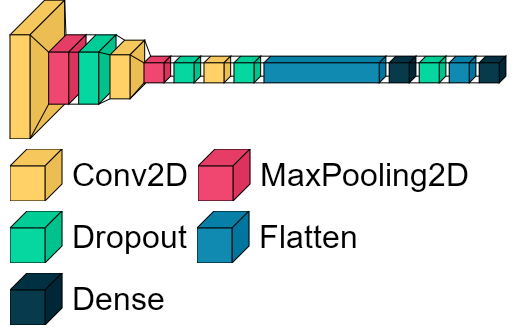

In [ ]:
visualise_keras(model_2,2)

In [ ]:
plot_accuracy_and_loss(history)

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



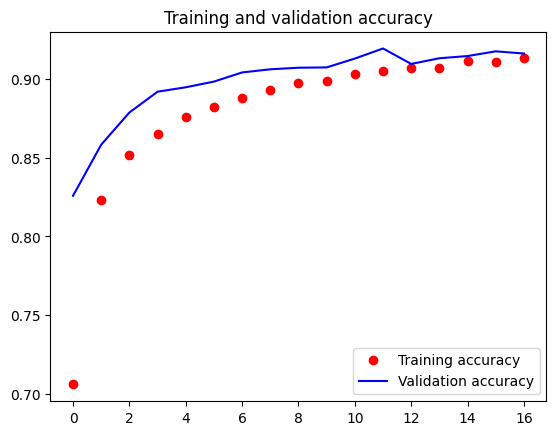

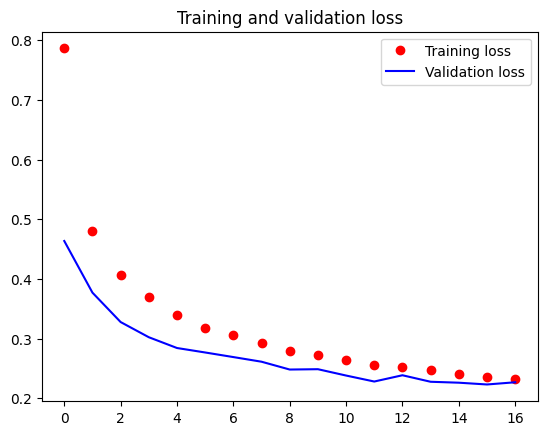

In [ ]:
plot_graph(history )

### Model Evaluation

### Showing performance based on predicted values

In [29]:
#locate index of '1' in each row
cnn_best = load_model('best_model2_DO.hdf5')
#Confirm loss and accuracy on the test data
cnn_best.evaluate(x_test,y_test)
#get the predictions for the test data
preds = cnn_best.predict(x_test)
preds = np.argmax(np.round(preds),axis=1)
print(preds)

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\backend.py:5582: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



157/157 [==============================] - 1s 6ms/step
[0 3 0 ... 0 6 0]


In [30]:
from sklearn.metrics import classification_report
labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
         "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
#get the indices to be plotted
correct = np.nonzero(preds==y_test)[0]
incorrect = np.nonzero(preds!=y_test)[0]
target_names = ["Item {} {}".format(labels[i], i) for i in range(10)]
print(classification_report(y_test, preds, target_names=target_names))

                    precision    recall  f1-score   support

Item T-shirt/top 0       0.41      0.89      0.56       524
    Item Trouser 1       1.00      0.92      0.96       506
   Item Pullover 2       0.84      0.43      0.57       496
      Item Dress 3       0.87      0.85      0.86       478
       Item Coat 4       0.73      0.68      0.70       488
     Item Sandal 5       0.94      0.95      0.95       525
      Item Shirt 6       0.70      0.34      0.45       486
    Item Sneaker 7       0.90      0.92      0.91       488
        Item Bag 8       0.97      0.94      0.96       516
 Item Ankle Boot 9       0.96      0.91      0.93       493

          accuracy                           0.79      5000
         macro avg       0.83      0.78      0.79      5000
      weighted avg       0.83      0.79      0.79      5000



#### Correct predictions

C:\Users\Xavier\AppData\Local\Temp\ipykernel_34792\3398885827.py:2: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



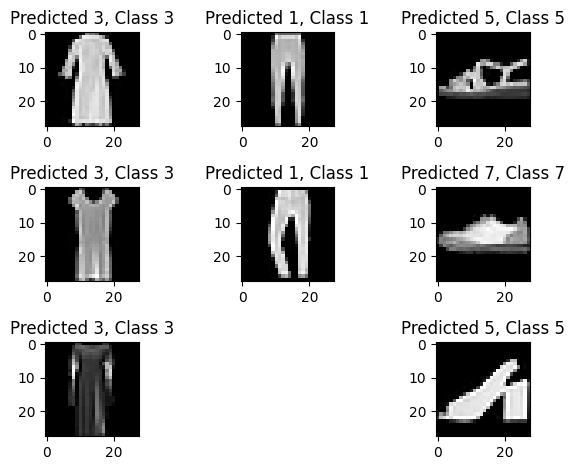

In [31]:
for i, correct_val in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[correct_val].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(preds[correct_val], y_test[correct_val]))
    plt.tight_layout()

#### Incorrect predictions

C:\Users\Xavier\AppData\Local\Temp\ipykernel_34792\398227340.py:2: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



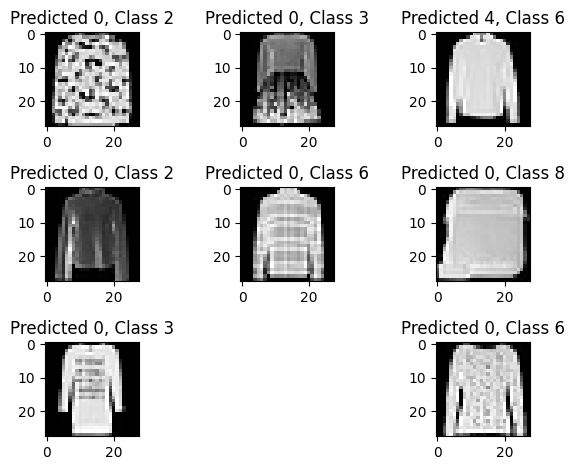

In [32]:
for i, incorrect_val in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[incorrect_val].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(preds[incorrect_val], y_test[incorrect_val]))
    plt.tight_layout()

# Tuning Model 2 

## Trying out with data augmentation

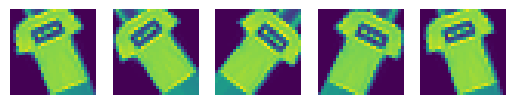

In [33]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    featurewise_center=False,  
    samplewise_center=False, 
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,  
    zca_whitening=False,
    rotation_range=50,
    width_shift_range=0.01, 
    height_shift_range=0.01, 
    horizontal_flip=False, 
    vertical_flip=False)

datagen.fit(x_train)

from matplotlib import pyplot as plt

gen = datagen.flow(x_train[1:2], batch_size=1)
for i in range(1, 6):
    plt.subplot(1,5,i)
    plt.axis("off")
    plt.imshow(gen.next().squeeze())
    plt.plot()
plt.show()

### Model 2 with dropout only

In [ ]:
def model_2_create():
    model_2 = Sequential()
    model_2.add(Conv2D(64, kernel_size=(3, 3),
                    activation='relu',
                    kernel_initializer='he_normal',
                    input_shape=(28,28,1)))
    model_2.add(MaxPooling2D((2, 2)))
    model_2.add(Dropout(0.25))
    model_2.add(Conv2D(64, (3, 3), activation='relu'))
    model_2.add(MaxPooling2D(pool_size=(2, 2)))
    model_2.add(Dropout(0.25))
    model_2.add(Conv2D(128, (3, 3), activation='relu'))
    model_2.add(Dropout(0.4))
    model_2.add(Flatten())
    model_2.add(Dense(128, activation='relu'))
    model_2.add(Dropout(0.3))
    model_2.add(Flatten())
    model_2.add(Dense(10, activation='softmax'))
    #loop through the optimizers
    model_2.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
        
    model_2.summary()

    return model_2

In [ ]:
# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stop on validation accuracy
monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 5)

# Save the best model as best_banknote_model.hdf5
model_checkpoint = ModelCheckpoint('data_aug_best_model2_DO.hdf5', save_best_only = True)

In [ ]:
model_2_data_augmented = model_2_create().fit(x_train, y_train,  
        batch_size=256,
          epochs=50,
          verbose=1,
          callbacks = [monitor_val_acc, model_checkpoint],
          validation_data = (x_valid, y_valid))

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 dropout_95 (Dropout)        (None, 13, 13, 64)        0         
                                                                 
 conv2d_76 (Conv2D)          (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 dropout_96 (Dropout)        (None, 5, 5, 64)        

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\backend.py:5582: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



235/235 [==============================] - 6s 16ms/step - loss: 0.7865 - accuracy: 0.7077 - val_loss: 0.4657 - val_accuracy: 0.8312
Epoch 2/50
235/235 [==============================] - 3s 13ms/step - loss: 0.4719 - accuracy: 0.8265 - val_loss: 0.3770 - val_accuracy: 0.8658
Epoch 3/50
235/235 [==============================] - 3s 13ms/step - loss: 0.4045 - accuracy: 0.8514 - val_loss: 0.3422 - val_accuracy: 0.8760
Epoch 4/50
235/235 [==============================] - 3s 12ms/step - loss: 0.3661 - accuracy: 0.8663 - val_loss: 0.3221 - val_accuracy: 0.8836
Epoch 5/50
235/235 [==============================] - 3s 11ms/step - loss: 0.3379 - accuracy: 0.8766 - val_loss: 0.2838 - val_accuracy: 0.8982
Epoch 6/50
235/235 [==============================] - 3s 11ms/step - loss: 0.3198 - accuracy: 0.8822 - val_loss: 0.2743 - val_accuracy: 0.9018
Epoch 7/50
235/235 [==============================] - 2s 11ms/step - loss: 0.3032 - accuracy: 0.8887 - val_loss: 0.2622 - val_accuracy: 0.9050
Epoch 8/50

In [ ]:
print('Test accuracy:', model_2_data_augmented.model.evaluate(x_test, y_test))

157/157 [==============================] - 1s 5ms/step - loss: 0.2359 - accuracy: 0.9182
Test accuracy: [0.23591265082359314, 0.9182000160217285]


#### Visualising model performance

Test loss: 0.23591265082359314
Test accuracy: 0.9182000160217285


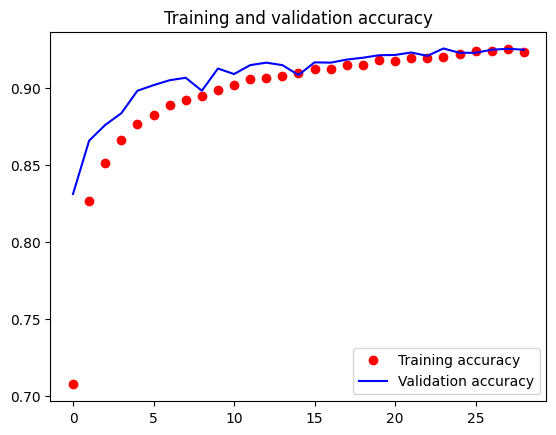

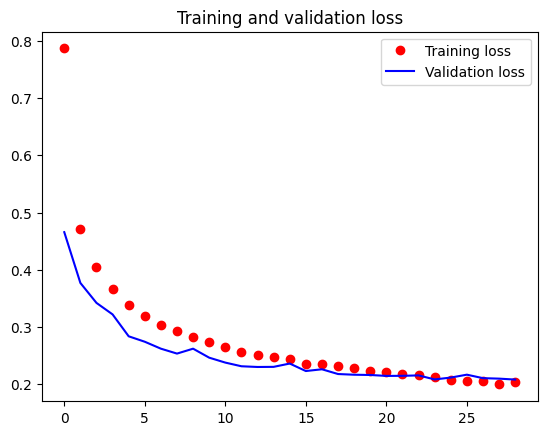

In [ ]:
plot_graph(model_2_data_augmented)

In [ ]:
plot_accuracy_and_loss(model_2_data_augmented)

#### Model Evaluation

In [34]:
print_classification('data_aug_best_model2_DO.hdf5')

 15/157 [=>............................] - ETA: 0s - loss: 0.1616 - accuracy: 0.9479 

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\backend.py:5582: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



157/157 [==============================] - 1s 5ms/step
[2 3 3 ... 0 6 2]
                    precision    recall  f1-score   support

Item T-shirt/top 0       0.79      0.87      0.83       524
    Item Trouser 1       0.99      0.98      0.99       506
   Item Pullover 2       0.91      0.87      0.89       496
      Item Dress 3       0.95      0.92      0.94       478
       Item Coat 4       0.88      0.88      0.88       488
     Item Sandal 5       0.99      0.98      0.98       525
      Item Shirt 6       0.77      0.77      0.77       486
    Item Sneaker 7       0.94      0.98      0.96       488
        Item Bag 8       0.99      0.98      0.98       516
 Item Ankle Boot 9       0.98      0.95      0.97       493

          accuracy                           0.92      5000
         macro avg       0.92      0.92      0.92      5000
      weighted avg       0.92      0.92      0.92      5000



### Model 2 with batchnormalization and dropout

In [ ]:
def model_2_create():
    model_2 = Sequential()
    model_2.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28,28,1),padding='same'))
    model_2.add(BatchNormalization())
    model_2.add(Dropout(0.2))
    model_2.add(Conv2D(32, kernel_size=3, activation='relu',padding='same'))
    model_2.add(Dropout(0.2))
    model_2.add(Conv2D(24, kernel_size=3, activation='relu',padding='same'))
    model_2.add(Dropout(0.4))
    model_2.add(Conv2D(64, kernel_size=3, activation='relu',padding='same'))
    model_2.add(MaxPooling2D(pool_size=(2,2)))
    model_2.add(Dropout(0.3))
    model_2.add(Flatten())
    model_2.add(Dense(128, activation='relu'))
    model_2.add(Dropout(0.3))
    model_2.add(Dense(10, activation='softmax'))

    model_2.compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')

    model_2.summary()
    return model_2

In [ ]:
# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stop on validation accuracy
monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 5)

# Save the best model as best_banknote_model.hdf5
model_checkpoint = ModelCheckpoint('data_aug_best_model2_DO_BN.hdf5', save_best_only = True)

In [ ]:
model_2_data_augmented = model_2_create().fit(x_train, y_train,  
        batch_size=256,
          epochs=50,
          verbose=1,
          callbacks = [monitor_val_acc, model_checkpoint],
          validation_data = (x_valid, y_valid))

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_78 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_8 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_99 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 conv2d_79 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 dropout_100 (Dropout)       (None, 28, 28, 32)        0         
                                                                 
 conv2d_80 (Conv2D)          (None, 28, 28, 24)        6936      
                                                     

#### Visualising model performance

In [ ]:
print('Test accuracy:', model_2_data_augmented.model.evaluate(x_test, y_test))

157/157 [==============================] - 2s 15ms/step - loss: 0.2105 - accuracy: 0.9302
Test accuracy: [0.21045173704624176, 0.9301999807357788]


Test loss: 0.21045173704624176
Test accuracy: 0.9301999807357788


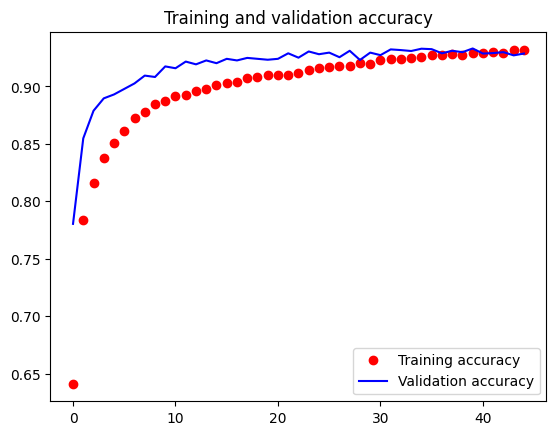

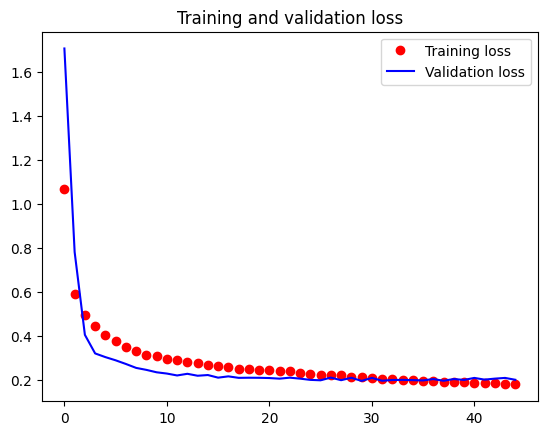

In [ ]:
plot_graph(model_2_data_augmented)

In [ ]:
plot_accuracy_and_loss(model_2_data_augmented)

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



#### Model Evaluation

In [ ]:
classification_report('data_aug_best_model2_DO_BN.hdf5')

## Trying out with regularization

In [ ]:
#Get back original x_train,x_test,x_valid
from sklearn.model_selection import train_test_split

x_valid, x_test, y_valid, y_test = train_test_split(x_rem,y_rem, test_size=0.5)
print(x_train.shape), print(y_train.shape)
print(x_valid.shape), print(y_valid.shape)
print(x_test.shape), print(y_test.shape)
x_train = x_train.reshape(60000,28,28,1)/255
x_test= x_test.reshape(5000,28,28,1)/255
x_valid = x_valid.reshape(5000,28,28,1)/255

(60000, 28, 28, 1)
(60000,)
(5000, 28, 28)
(5000,)
(5000, 28, 28)
(5000,)


### Model 2 with dropout only

In [ ]:
from keras import regularizers
from keras.optimizers import Adam
def model_2_create():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),
                    activation='relu',         
                    kernel_initializer='he_normal', 
                    input_shape=(28,28,1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    #loop through the optimizers
    adam = Adam(lr=0.0001, decay=1e-6)
    model.compile(optimizer=adam,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint('regularizer_model_2_DO.hdf5', save_best_only = True)
# Early stop on validation accuracy     
monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 5)

In [ ]:
history = model_2_create().fit(x_train,y_train,
        batch_size=256,
          epochs=50,
          verbose=1,
          callbacks=[checkpoint, monitor_val_acc],
          validation_data = (x_valid, y_valid))

Epoch 1/50
235/235 [==============================] - 5s 15ms/step - loss: 1.8492 - accuracy: 0.3636 - val_loss: 84.9894 - val_accuracy: 0.3816
Epoch 2/50
235/235 [==============================] - 3s 12ms/step - loss: 1.0866 - accuracy: 0.5942 - val_loss: 88.9626 - val_accuracy: 0.4854
Epoch 3/50
235/235 [==============================] - 3s 12ms/step - loss: 0.9537 - accuracy: 0.6441 - val_loss: 82.6277 - val_accuracy: 0.5178
Epoch 4/50
235/235 [==============================] - 3s 12ms/step - loss: 0.8908 - accuracy: 0.6654 - val_loss: 80.5543 - val_accuracy: 0.5248
Epoch 5/50
235/235 [==============================] - 3s 12ms/step - loss: 0.8470 - accuracy: 0.6809 - val_loss: 71.5406 - val_accuracy: 0.5568
Epoch 6/50
235/235 [==============================] - 3s 13ms/step - loss: 0.8134 - accuracy: 0.6906 - val_loss: 65.7700 - val_accuracy: 0.5798
Epoch 7/50
235/235 [==============================] - 3s 13ms/step - loss: 0.7858 - accuracy: 0.7027 - val_loss: 61.6513 - val_accuracy:

KeyboardInterrupt: 

#### Visualising model performance

Test loss: 401.93499755859375
Test accuracy: 0.5863999724388123


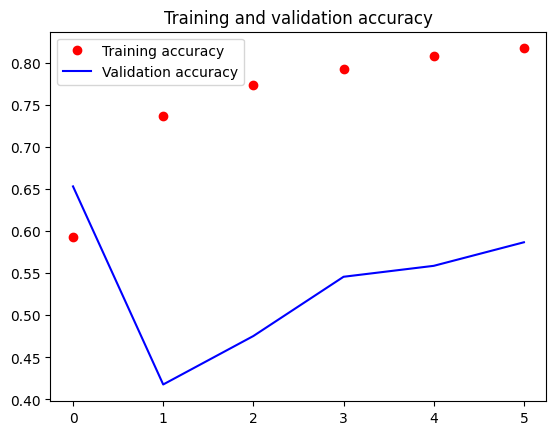

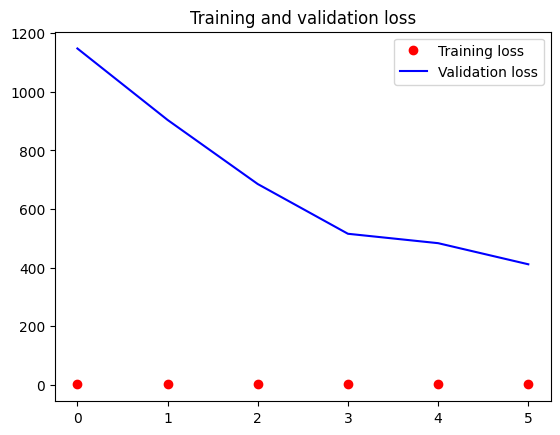

In [ ]:
plot_graph(history)

In [ ]:
plot_accuracy_and_loss(history)

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\plotly\tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



#### Model Evaluation

In [ ]:
classification_report('regularizer_model_2_DO.hdf5')

c:\Users\Xavier\anaconda3\envs\gpu_env\lib\site-packages\keras\backend.py:5582: UserWarning:

"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?



157/157 [==============================] - 1s 6ms/step
[7 9 0 ... 3 7 0]


### Model 2 with Batch Normalization

In [ ]:
def build_model_l2(l2_loss_lambda):
    """
    builds Keras model with L2 regularization applied to each Conv2D and Dense layers
	@params:
	- l2_loss_lambda: float, controls amount of regularization to apply
	     (optional, default=None)
    """
    
    l2 = None if l2_loss_lambda is None else regularizers.l2(l2_loss_lambda)
    if l2 is not None:
        print('Using L2 regularization - l2_loss_lambda = %.4f' % l2_loss_lambda)    
    
    model = Sequential([
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2, 
               input_shape=(28, 28, 1)),
        BatchNormalization(),
        Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2),
        BatchNormalization(),
        Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2),
        BatchNormalization(),        
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2),
        BatchNormalization(),
        Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2),
        BatchNormalization(),    
        MaxPooling2D(pool_size=(2, 2)),   
        
        Flatten(),
        
        Dense(1024, activation='relu', kernel_regularizer=l2),
        
        Dense(512, activation='relu', kernel_regularizer=l2),
        
        Dense(10, activation='softmax')
    ])
    
    adam = Adam(lr=0.0001, decay=1e-6)
    model.compile(optimizer=adam,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    print(model.summary())
    return model

In [ ]:
# Import the EarlyStopping and ModelCheckpoint callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint('regularizer_model_2_DO_BN.hdf5', save_best_only = True)
# Early stop on validation accuracy
monitor_val_acc = EarlyStopping(monitor = 'val_accuracy', patience = 100)

In [ ]:
history = build_model_l2(l2_loss_lambda=0.0000010).fit(x_train,y_train,
        batch_size=64,
          epochs=50,
          verbose=1,
          callbacks=[checkpoint, monitor_val_acc],
          validation_data = (x_valid, y_valid))

Using L2 regularization - l2_loss_lambda = 0.0000
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_127 (Conv2D)         (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_33 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_128 (Conv2D)         (None, 26, 26, 64)        36928     
                                                                 
 batch_normalization_34 (Bat  (None, 26, 26, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
   

Test loss: 189.08969116210938
Test accuracy: 0.5633999705314636


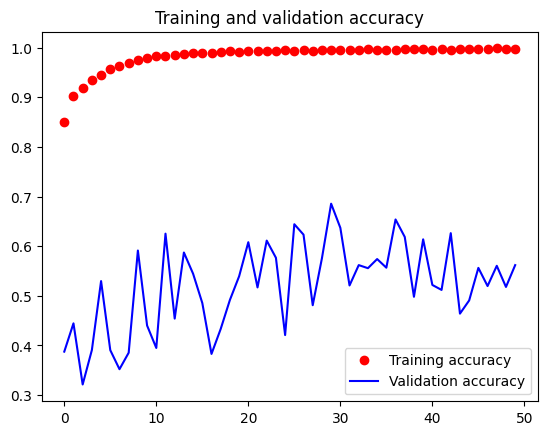

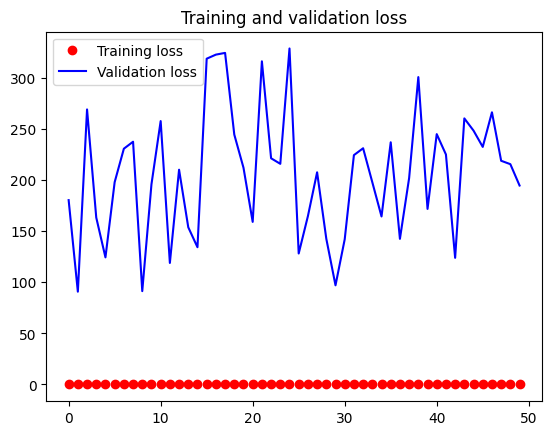

In [ ]:
score = history.model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
def model_2_create():
    model_2 = Sequential()
    model_2.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28,28,1),padding='same'))
    model_2.add(BatchNormalization())
    model_2.add(Dropout(0.2))
    model_2.add(Conv2D(32, kernel_size=3, activation='relu',padding='same'))
    model_2.add(Dropout(0.2))
    model_2.add(Conv2D(24, kernel_size=3, activation='relu',padding='same'))
    model_2.add(Dropout(0.4))
    model_2.add(Conv2D(64, kernel_size=3, activation='relu',padding='same'))
    model_2.add(MaxPooling2D(pool_size=(2,2)))
    model_2.add(Dropout(0.3))
    model_2.add(Flatten())
    model_2.add(Dense(128, activation='relu'))
    model_2.add(Dropout(0.3))
    model_2.add(Dense(10, activation='softmax'))

    model_2.compile(optimizer='adam', metrics=['accuracy'], loss='sparse_categorical_crossentropy')

    model_2.summary()
    return model_2

## Trying out different optimizers methods

In [ ]:
#Get back original x_train,x_test,x_valid
from sklearn.model_selection import train_test_split

x_valid, x_test, y_valid, y_test = train_test_split(x_rem,y_rem, test_size=0.5)
print(x_train.shape), print(y_train.shape)
print(x_valid.shape), print(y_valid.shape)
print(x_test.shape), print(y_test.shape)
x_train = x_train.reshape(60000,28,28,1)/255
x_test= x_test.reshape(5000,28,28,1)/255
x_valid = x_valid.reshape(5000,28,28,1)/255

(60000, 28, 28, 1)
(60000,)
(5000, 28, 28)
(5000,)
(5000, 28, 28)
(5000,)


In [ ]:
def tune_model_2(optimizer):

    activation = ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),
                    activation='relu',
                    kernel_initializer='he_normal',
                    input_shape=(28,28,1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    #loop through the optimizers
    model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])


    model.summary()
    return model

In [ ]:
optimizers = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']
for i in optimizers:
    model = tune_model_2(i)
    history = model.fit(x_train,y_train,
        batch_size=256,
          epochs=50,
          verbose=1,
          callbacks=[checkpoint, monitor_val_acc],
          validation_data = (x_valid, y_valid))
    model.save('optimizer_model_2_{}.hdf5'.format(i))

NameError: name 'Sequential' is not defined

NameError: name 'tuner' is not defined

Padding/Without padding

# Final Model 2 

# Trying out Model 3 - VGG